# Within a single author's life, is there any pattern to resonance?

Because we idly speculated that it might decline ...

In [38]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, zscore
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [25]:
zdata = pd.read_csv('../supp2results/zdata.tsv', sep = '\t', index_col= 'docid')

In [26]:
meta = pd.read_csv('../supplement2/supp2nationalitymeta.tsv', sep = '\t', index_col = 'docid')

#### get some extra metadata for author birth and death dates

In [18]:
work = pd.read_csv('../../noveltmmeta/workmeta.tsv', sep = '\t', index_col = 'docid', low_memory = False)

I'm going to actually add ```author``` to zdata, but keep ```authordate``` in work, because there can be different authordates for the same author, and it complicates matters to do a join.

In [27]:
print(zdata.shape)
zdata = zdata.join(meta.author, how = 'inner')
print(zdata.shape)

(39817, 40)
(39817, 41)


In [8]:
zdata.columns

Index(['novelty_1.0_10', 'novelty_1.0_25', 'novelty_1.0_40', 'novelty_0.2_10',
       'novelty_0.2_25', 'novelty_0.2_40', 'novelty_0.05_10',
       'novelty_0.05_25', 'novelty_0.05_40', 'novelty_0.025_10',
       'novelty_0.025_25', 'novelty_0.025_40', 'transience_1.0_10',
       'transience_1.0_25', 'transience_1.0_40', 'transience_0.2_10',
       'transience_0.2_25', 'transience_0.2_40', 'transience_0.05_10',
       'transience_0.05_25', 'transience_0.05_40', 'transience_0.025_10',
       'transience_0.025_25', 'transience_0.025_40', 'resonance_1.0_10',
       'resonance_1.0_25', 'resonance_1.0_40', 'resonance_0.2_10',
       'resonance_0.2_25', 'resonance_0.2_40', 'resonance_0.05_10',
       'resonance_0.05_25', 'resonance_0.05_40', 'resonance_0.025_10',
       'resonance_0.025_25', 'resonance_0.025_40', 'inferreddate', 'isus',
       'latestcomp', 'allcopiesofwork', 'author'],
      dtype='object')

#### test the average correlation of publication date with resonance across an author's life

In [50]:
correlations = []
ages = []
resonances = []
errors = 0

grouped = zdata.groupby('author')
for auth, df in grouped:
    rows = df.shape[0]
    if rows > 3:
        r, p = pearsonr(df['resonance_0.05_25'], df['latestcomp'])
        correlations.append(r)
        
        if not np.isnan(r):
            docid = df.index[0]
            if docid not in work.index:
                errors += 1
                continue
                
            authordate = work.loc[docid, 'authordate']
            if pd.isnull(authordate):
                continue
            if len(authordate) > 5 and '-' in authordate:
                try:
                    birth = int(authordate[0 : 4])
                except:
                    continue
            
                idx = random.sample([df.index.tolist()], 1)[0]
                date = df.loc[idx, 'latestcomp'].values[0]
                age = date - birth
                if age > 90:
                    continue
                else:
                    ages.append(age)
                    resonances.append(df.loc[idx, 'resonance_0.05_25'].values[0])        

print("There are ", sum(np.isnan(correlations)), " NaN vals.")       
correlations = np.array(correlations)
correlations = correlations[~np.isnan(correlations)]
print('And ', len(correlations), ' non-NaN.')

print('Raw mean: ', np.nanmean(correlations))
print()
fisher_transformed = np.arctanh(correlations)
themean = np.mean(fisher_transformed)
print('Better estimate: ', np.tanh(themean))

There are  394  NaN vals.
And  1280  non-NaN.
Raw mean:  -0.503245459878

Better estimate:  -0.656071653109


/Users/tunder/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


An average correlation of -0.65 is bloody strong.

It suggests that resonance goes down as you get older.

But hey, it's sort of weird to average *r* across a lot of datasets with small *n*. So we also randomly pulled out some works, and recorded author age and resonance in each case.

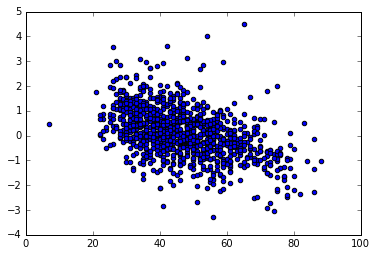

In [49]:
plt.scatter(ages, resonances)
plt.show()

In [51]:
pearsonr(ages, resonances)

(-0.46413102008780033, 1.3776690070422823e-58)

### Interpretation

We need to be a little cautious, because we don't know how close books are to date of first publication on average. Maybe this is just telling us that reprints lack resonance, because (obvs) they're dated too late.

So let's take some sets where we know they're dated to firstpub.

In [52]:
hypothesis_meta = pd.read_csv('../supplement2/hypothesis_wnationality_meta.tsv', sep = '\t', index_col = 'docid')

In [54]:
reviewset = hypothesis_meta[hypothesis_meta.reviewed].index.tolist() + hypothesis_meta[hypothesis_meta.contrast4reviewed].index.tolist()

In [55]:
len(reviewset)

1143

In [61]:
puredata = zdata.loc[reviewset, :]
correlations = []
ages = []
resonances = []
errors = 0

grouped = puredata.groupby('author')
for auth, df in grouped:
    rows = df.shape[0]
    if rows > 2:
        r, p = pearsonr(df['resonance_0.05_25'], df['latestcomp'])
        correlations.append(r)
        
        if not np.isnan(r):
            docid = df.index[0]
            if docid not in work.index:
                errors += 1
                continue
                
            authordate = work.loc[docid, 'authordate']
            if pd.isnull(authordate):
                continue
            if len(authordate) > 5 and '-' in authordate:
                try:
                    birth = int(authordate[0 : 4])
                except:
                    continue
            
                for idx in df.index:
                    date = df.loc[idx, 'latestcomp']
                    age = date - birth
                    if age > 90:
                        continue
                    else:
                        ages.append(age)
                        resonances.append(df.loc[idx, 'resonance_0.05_25'])       

print("There are ", sum(np.isnan(correlations)), " NaN vals.")       
correlations = np.array(correlations)
correlations = correlations[~np.isnan(correlations)]
print('And ', len(correlations), ' non-NaN.')

print('Raw mean: ', np.nanmean(correlations))
print()
fisher_transformed = np.arctanh(correlations)
themean = np.mean(fisher_transformed)
print('Better estimate: ', np.tanh(themean))

There are  5  NaN vals.
And  26  non-NaN.
Raw mean:  -0.4936872616

Better estimate:  -0.842910162153


/Users/tunder/miniconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


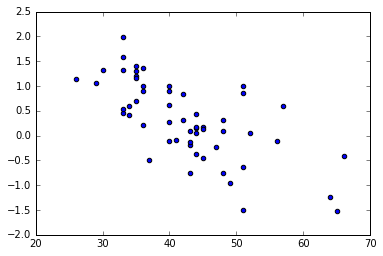

In [62]:
plt.scatter(ages, resonances)
plt.show()

In [63]:
pearsonr(ages, resonances)

(-0.68782060192148164, 6.5725592010968643e-09)

### Conclusion

Publish books early.